In [326]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from statsmodels.stats.multitest import multipletests

# Define experiments

In [87]:
experiments = {"rpl22_oe": [
    ['LNCaP_GFP_1',
     'LNCaP_GFP_2',
     'LNCaP_GFP_3'],
    ['LNCaP_RPL22_1',
     'LNCaP_RPL22_2',
     'LNCaP_RPL22_3']
],
    "rpl22l1_oe": [
    ['CAL851_GFP_1',
     'CAL851_GFP_2',
     'CAL851_GFP_3'],
    ['CAL851_RPL22L1_1',
     'CAL851_RPL22L1_2',
     'CAL851_RPL22L1_3']
],
    "sh704": [
    ['LNCaP_shLuc_1',
     'LNCaP_shLuc_2',
     'LNCaP_shLuc_3'],
    ['LNCaP_sh704_1',
     'LNCaP_sh704_2',
     'LNCaP_sh704_3']
],
    "sh705": [
    ['LNCaP_shLuc_1',
     'LNCaP_shLuc_2',
     'LNCaP_shLuc_3'],
    ['LNCaP_sh705_1',
     'LNCaP_sh705_2',
     'LNCaP_sh705_3']
]
}

experiment_ids = ["rpl22_oe","rpl22l1_oe","sh704","sh705"]

# Load TPMS and sleuth results

In [102]:
kallisto_sleuth_path = "../data/processed/kallisto_sleuth_merge/"

rpl22_oe_genes = pd.read_csv(kallisto_sleuth_path + "rpl22_oe_genes.txt", sep="\t", index_col=0)
rpl22l1_oe_genes = pd.read_csv(kallisto_sleuth_path + "rpl22l1_oe_genes.txt", sep="\t", index_col=0)
sh704_genes = pd.read_csv(kallisto_sleuth_path + "sh704_genes.txt", sep="\t", index_col=0)
sh705_genes = pd.read_csv(kallisto_sleuth_path + "sh705_genes.txt", sep="\t", index_col=0)

rpl22_oe_transcripts = pd.read_csv(kallisto_sleuth_path + "rpl22_oe_transcripts.txt", sep="\t", index_col=0)
rpl22l1_oe_transcripts = pd.read_csv(kallisto_sleuth_path + "rpl22l1_oe_transcripts.txt", sep="\t", index_col=0)
sh704_transcripts = pd.read_csv(kallisto_sleuth_path + "sh704_transcripts.txt", sep="\t", index_col=0)
sh705_transcripts = pd.read_csv(kallisto_sleuth_path + "sh705_transcripts.txt", sep="\t", index_col=0)

# Differential expression

In [103]:
def as_si(x, ndp):
    """
    Convert a number to scientific notation

    Parameters
    ----------
    x : float
        number to convert
    ndp: float
        number of decimal places

    Returns
    -------
    x_si : string
        x formatted in scientific notation
    """

    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    x_si = r'{m:s} × $10^{{{e:d}}}$'.format(m=m, e=int(e))

    return x_si

In [470]:
control_color = "#393e46"
treatment_color = "#e23e57"
alpha = 0.5


def bars(annotation_id, experiment_id, diff_results, ax=None, xlabel=None, ylabel=None):

    if ax is None:
        ax = plt.subplot(111)

    if xlabel is None:
        xlabel = experiment_id

    if ylabel is None:
        ylabel = "mRNA expression, log2(TPM + 1)"
        
    # get experiment controls and treatments
    select_abundance = diff_results.loc[annotation_id]

    controls = experiments[experiment_id][0]
    treatments = experiments[experiment_id][1]

    # extract control and treatment values
    control_values = np.log2(select_abundance[controls].astype(np.float64)+1)
    treatment_values = np.log2(
        select_abundance[treatments].astype(np.float64)+1)

    control_mean = np.mean(control_values)
    treatment_mean = np.mean(treatment_values)

    # draw bars based on means
    offset = 0.05
    width = 0.4

    control_rect = Rectangle([offset, 0],
                             width,
                             control_mean,
                             color=control_color,
                             alpha=alpha,
                             linewidth=0,
                             zorder=-100
                             )
    ax.add_patch(control_rect)

    treatment_rect = Rectangle([0.5+offset, 0],
                               width,
                               treatment_mean,
                               color=treatment_color,
                               alpha=alpha,
                               linewidth=0,
                               zorder=-100
                               )
    ax.add_patch(treatment_rect)

    # draw the points themselves
    ax.scatter([0.25-width/3, 0.25, 0.25+width/3],
               control_values,
               color=control_color,
               linewidth=1,
               s=32,
               edgecolor="black"
               )
    ax.scatter([0.75-width/3, 0.75, 0.75+width/3],
               treatment_values,
               color=treatment_color,
               linewidth=1,
               s=32,
               edgecolor="black"
               )

    # draw mean lines
    ax.axhline(control_mean, offset, offset+width,
               linewidth=3, color=control_color, zorder=0,
               solid_capstyle="butt"
               )
    ax.axhline(treatment_mean, 0.5+offset, 0.5+offset+width,
               linewidth=3, color=treatment_color, zorder=0,
               solid_capstyle="butt")

    # figure formatting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks([])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # space out axes
    ax.spines['bottom'].set_position(('axes', -0.025))
    ax.spines['left'].set_position(('axes', -0.05))

    # set y minimum to 0
    plt.ylim(0)

    y_max = max(list(control_values)+list(treatment_values))

    if not np.isnan(select_abundance["pval"]):

        qval = as_si(select_abundance["pval"], 0)
        ax.text(0.5, y_max*1.2, qval, ha="center", fontsize=8)

    return ax, y_max


def all_bars(annotation_id, annotation_type):

    f, axes = plt.subplots(1, 4, sharey=True, figsize=(4.5, 3))

    maxes = []

    if annotation_type == "transcript":
        sleuth_sets = [rpl22_oe_transcripts,
                       rpl22l1_oe_transcripts,
                       sh704_transcripts,
                       sh705_transcripts
                       ]

    elif annotation_type == "gene":
        sleuth_sets = [rpl22_oe_genes,
                       rpl22l1_oe_genes,
                       sh704_genes,
                       sh705_genes
                       ]
        
    elif annotation_type == "splicing":
        sleuth_sets = [rpl22_oe_rmats,
                       rpl22l1_oe_rmats,
                       sh704_rmats,
                       sh705_rmats
                       ]

    for sleuth_idx, sleuth_set in enumerate(sleuth_sets):
        ax = axes[sleuth_idx]

        ax, y_max = bars(annotation_id,
                         experiment_ids[sleuth_idx],
                         sleuth_set,
                         ax=ax,
                         ylabel="")

        maxes.append(y_max)

        if sleuth_idx > 0:

            ax.spines["left"].set_visible(False)
            ax.tick_params(axis='y', which='both', right=False,
                           left=False, labelleft=False)

    axes[0].set_xlabel("+RPL22")
    axes[1].set_xlabel("+RPL22L1")
    axes[2].set_xlabel("shRPL22L11")
    axes[3].set_xlabel("shRPL22L12")

    axes[0].set_ylabel("mRNA expression, log2(TPM+1)")

    plt.ylim(0, max(maxes)*1.25)

    plt.subplots_adjust(wspace=0.25)

    legend_background = "#eaeaea"

    legend_elements = [Patch(label='Control',
                             color=control_color, alpha=alpha),
                       Patch(label='Treatment',
                             color=treatment_color, alpha=alpha)]

    legend = plt.legend(handles=legend_elements,
                        loc='upper left', bbox_to_anchor=(1, 1),)
    frame = legend.get_frame()
    frame.set_facecolor(legend_background)
    frame.set_edgecolor(legend_background)

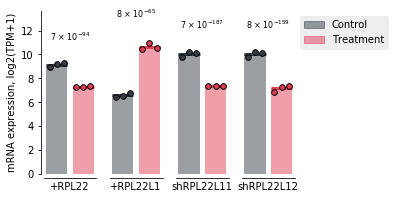

In [421]:
all_bars("ENSG00000163584","gene")

plt.savefig("../plots/rpl22l1_ENSG00000163584_expression.pdf",bbox_inches="tight",background="transparent")

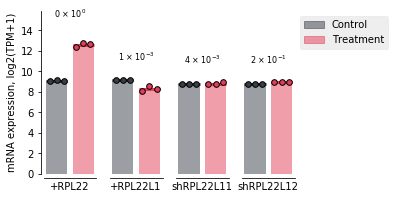

In [422]:
all_bars("ENSG00000116251","gene")

plt.savefig("../plots/rpl22_ENSG00000116251_expression.pdf",bbox_inches="tight",background="transparent")

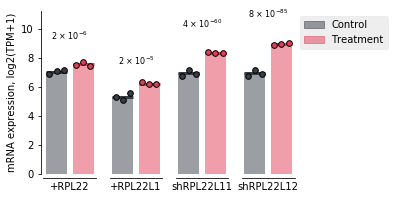

In [428]:
all_bars("ENSG00000135679","gene")

plt.savefig("../plots/mdm2_ENSG00000135679_expression.pdf",bbox_inches="tight",background="transparent")

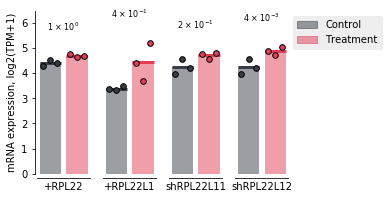

In [430]:
all_bars("ENSG00000198625","gene")

plt.savefig("../plots/mdm4_ENSG00000198625_expression.pdf",bbox_inches="tight",background="transparent")

## Volcano plots

In [96]:
def compute_medians(sleuth_diff, experiment):
    sleuth_diff["control_median"] = sleuth_diff[experiments[experiment][0]].median(axis=1)
    sleuth_diff["treatment_median"] = sleuth_diff[experiments[experiment][1]].median(axis=1)
    sleuth_diff["median_foldchange"] = sleuth_diff["treatment_median"]/sleuth_diff["control_median"]

In [122]:
compute_medians(rpl22_oe_genes,"rpl22_oe")
compute_medians(rpl22l1_oe_genes,"rpl22l1_oe")
compute_medians(sh704_genes,"sh704")
compute_medians(sh705_genes,"sh705")

compute_medians(rpl22_oe_transcripts,"rpl22_oe")
compute_medians(rpl22l1_oe_transcripts,"rpl22l1_oe")
compute_medians(sh704_transcripts,"sh704")
compute_medians(sh705_transcripts,"sh705")

/Users/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


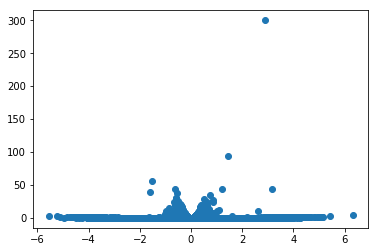

In [136]:
sleuth_diff = rpl22l1_oe_transcripts

plt.scatter(sleuth_diff["b"],-np.log10(sleuth_diff["qval"]+10**(-300)))

# plt.xlim(-5,5)

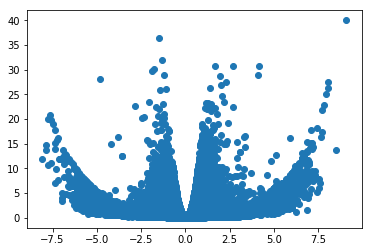

In [423]:
sleuth_diff = rpl22l1_oe_transcripts

plt.scatter(sleuth_diff["b"],-np.log10(sleuth_diff["qval"]+10**(-300)))

# plt.xlim(-5,5)

# Differential splicing

In [464]:
rpl22_oe_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22_oe.txt",sep="\t",index_col=0)
rpl22l1_oe_rmats = pd.read_csv("../data/processed/rmats_merge/rpl22l1_oe.txt",sep="\t",index_col=0)
sh704_rmats = pd.read_csv("../data/processed/rmats_merge/sh704.txt",sep="\t",index_col=0)
sh705_rmats = pd.read_csv("../data/processed/rmats_merge/sh705.txt",sep="\t",index_col=0)

In [465]:
rpl22_oe_rmats = rpl22_oe_rmats.rename({"PValue":"pval"},axis=1)
rpl22l1_oe_rmats = rpl22l1_oe_rmats.rename({"PValue":"pval"},axis=1)
sh704_rmats = sh704_rmats.rename({"PValue":"pval"},axis=1)
sh705_rmats = sh705_rmats.rename({"PValue":"pval"},axis=1)

(<matplotlib.axes._subplots.AxesSubplot at 0x1a62c9d9d0>, 0.12829340100981756)

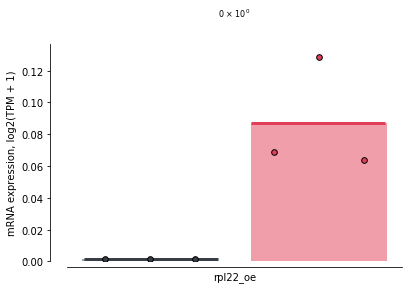

In [447]:
bars("RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923", 
     "rpl22_oe", 
     rpl22_oe_rmats)

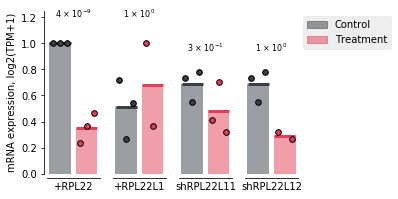

In [471]:
all_bars("UBAP2L_ENSG00000143569_154241837_154241888_154241232_154241430_154243356_154243649", 
     "splicing")

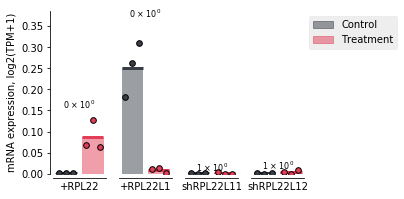

In [474]:
all_bars("RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176", 
     "splicing")

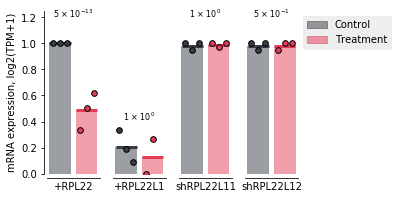

In [476]:
all_bars("MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436", 
     "splicing")

In [473]:
rpl22_oe_rmats

,splice_type,GeneID,geneSymbol,pval,FDR,gene_id,LNCaP_GFP_1,LNCaP_GFP_2,LNCaP_GFP_3,LNCaP_RPL22_1,LNCaP_RPL22_2,LNCaP_RPL22_3
exon_gene_id,,,,,,,,,,,,
RPL22L1_ENSG00000163584_170585801_170585990_170585801_170585923_170586086_170586176,A3SS,ENSG00000163584,RPL22L1,0.000000e+00,0.000000e+00,RPL22L1_ENSG00000163584,0.001,0.001,0.001,0.049,0.093,0.045
ARL13B_ENSG00000169379_93715391_93715528_93715406_93715528_93714717_93714788,A3SS,ENSG00000169379,ARL13B,4.996004e-15,9.657275e-12,ARL13B_ENSG00000169379,1.000,1.000,1.000,0.000,0.000,0.091
MDM4_ENSG00000198625_204506586_204506625_204501318_204501374_204507336_204507436,SE,ENSG00000198625,MDM4,6.661338e-16,2.265788e-11,MDM4_ENSG00000198625,1.000,1.000,1.000,0.125,0.176,0.300
TBC1D7_ENSG00000145979_13328527_13328763_13328547_13328763_13327018_13327138,A5SS,ENSG00000145979,TBC1D7,1.889489e-12,4.774738e-09,TBC1D7_ENSG00000145979,0.000,0.000,0.000,1.000,0.600,1.000
MDM4_ENSG00000198625_204506557_204506625_204501318_204501374_204507336_204507436,SE,ENSG00000198625,MDM4,4.847234e-13,8.243690e-09,MDM4_ENSG00000198625,1.000,1.000,1.000,0.263,0.417,0.533
LSS_ENSG00000160285_47610989_47611149_47608359_47608735_47611794_47613401,SE,ENSG00000160285,LSS,7.474021e-13,8.474045e-09,LSS_ENSG00000160285,1.000,1.000,0.992,0.810,0.912,0.889
LSS_ENSG00000160285_47610979_47611149_47608054_47608735_47611794_47611873,SE,ENSG00000160285,LSS,1.049494e-12,8.924371e-09,LSS_ENSG00000160285,1.000,1.000,0.992,0.810,0.909,0.886
A1BG-AS1_ENSG00000268895_58864686_58864840_58859116_58859210_58865079_58865223,SE,ENSG00000268895,A1BG-AS1,2.153833e-12,1.321584e-08,A1BG-AS1_ENSG00000268895,1.000,1.000,1.000,0.000,0.250,0.250
AC010967.2_ENSG00000228033_52959879_52959915_52953809_52953956_53124380_53124442,SE,ENSG00000228033,AC010967.2,2.331246e-12,1.321584e-08,AC010967.2_ENSG00000228033,1.000,1.000,1.000,0.333,0.200,0.200
